# ヴァイスシュヴァルツ ダメージシミュレーション
ダメージの通過をモンテカルロで試行し、試行回数のチューニングやヒストグラム出力まで行うノートブックです。


In [1]:
import random
from typing import Optional

import matplotlib.pyplot as plt
from matplotlib import font_manager

from ws_sim.main_phase import (
    run_main_phase_and_battle,
)
from ws_sim.monte_carlo import (
    DamageEvent,
    DeckConfig,
    apply_magic_stone_effect,
    cumulative_probability_at_least,
    simulate_trials,
    tune_trial_count,
    main_phase_fourth_cancel_bonus_damage,
    reveal_nine_clock_climaxes
)
from ws_sim.plotting import plot_cumulative_histogram

japanese_font_candidates = [
    "Noto Sans CJK JP",
    "Noto Sans JP",
    "IPAPGothic",
    "IPAexGothic",
    "Yu Gothic",
    "Hiragino Sans",
    "Meiryo",
]
available_fonts = {f.name for f in font_manager.fontManager.ttflist}
chosen_fonts = [name for name in japanese_font_candidates if name in available_fonts]
if chosen_fonts:
    plt.rcParams["font.family"] = chosen_fonts
    plt.rcParams["font.sans-serif"] = chosen_fonts
else:
    print("日本語フォントが見つからなかったためデフォルトを使用します。")
plt.rcParams["axes.unicode_minus"] = False

TRIALS = 5000
BASE_SEED = 314
TUNE_SEED = 42
WAITING_ROOM_SEED = 7
MAIN_PHASE_SEED = 2024


def probabilities_from_damages(damages):
    thresholds = range(0, max(damages) + 1)
    return cumulative_probability_at_least(damages, thresholds)


def show_histogram(probabilities, *, title: str, trials: Optional[int] = None, filename: Optional[str] = None):
    fig, ax = plot_cumulative_histogram(probabilities)
    ax.set_title(title)
    max_threshold = max(probabilities.keys()) if probabilities else 0
    ax.set_xlim(left=0, right=max_threshold + 0.9)
    ax.set_xticks(range(0, max_threshold + 1))
    if trials is not None:
        ax.text(0.99, 0.95, f"trials={trials}", transform=ax.transAxes, ha="right", va="top")
    plt.show()
    if filename:
        fig.savefig(filename, bbox_inches="tight")
    return fig, ax


## アタックトリガーと効果ダメージの分離

攻撃ダメージ（ソウルトリガーが乗る可能性あり）と、トリガー処理を経由しない効果ダメージを `DamageEvent` で区別します。
ソウル+1トリガーを含めて攻撃解決を再現したい場合は、攻撃側の山札を表す `DeckConfig.attacking_deck_size` と `DeckConfig.attacking_soul_trigger_cards` を設定してください。


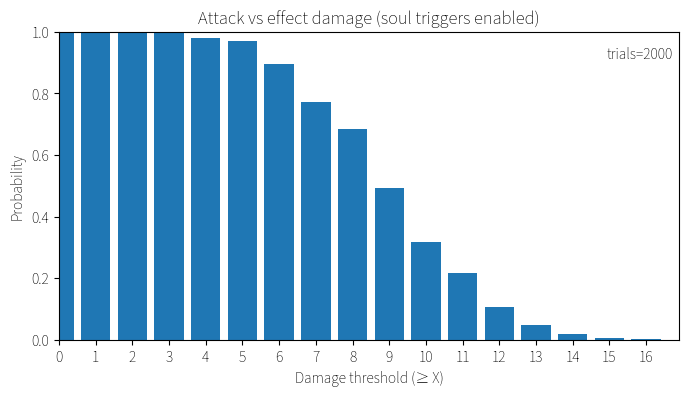

Trials used: 2000, mean damage=8.51, P(>=10)=0.318


In [2]:
damage_sequence = [
    DamageEvent(base_damage=2, is_attack=False),
    DamageEvent(base_damage=3, is_attack=True),
    DamageEvent(base_damage=3, is_attack=False),
    DamageEvent(base_damage=2, is_attack=False),
    DamageEvent(base_damage=3, is_attack=True),
    DamageEvent(base_damage=3, is_attack=False),
    DamageEvent(base_damage=2, is_attack=False),
    DamageEvent(base_damage=3, is_attack=True),
]

deck = DeckConfig(
    deck_cards=20,
    deck_climax_cards=6,
    attacking_deck_size=25,
    attacking_soul_trigger_cards=10,
)

chosen_trials, history = tune_trial_count(
    damage_sequence,
    deck,
    threshold=6,
    target_error=0.02,
    min_trials=500,
    seed=TUNE_SEED,
)
damages = simulate_trials(damage_sequence, deck, trials=chosen_trials, seed=TUNE_SEED)
probabilities = probabilities_from_damages(damages)

show_histogram(
    probabilities,
    title="Attack vs effect damage (soul triggers enabled)",
    trials=chosen_trials,
    filename="../artifacts/damage_hist.png",
)

print(f"Trials used: {chosen_trials}, mean damage={sum(damages)/len(damages):.2f}, P(>=10)={probabilities.get(10, 0):.3f}")


## 途中リフレッシュを待機室事前投入でシミュレートする

ダメージシーケンス開始前にすでに待機室へ送られているカードを再現するため、`DeckConfig` の `waiting_room_cards` と `waiting_room_climax_cards` を使用します。
減った山札から引き込み、山札が尽きたら待機室をシャッフルして戻し、シーケンス中にそのシャッフルが起きた場合は自動でリフレッシュペナルティ1点を適用します。
これにより、意図的に圧縮した山札のラインを検証したり、リフレッシュタイミングがダメージカーブに与える影響を手軽に確認できます。



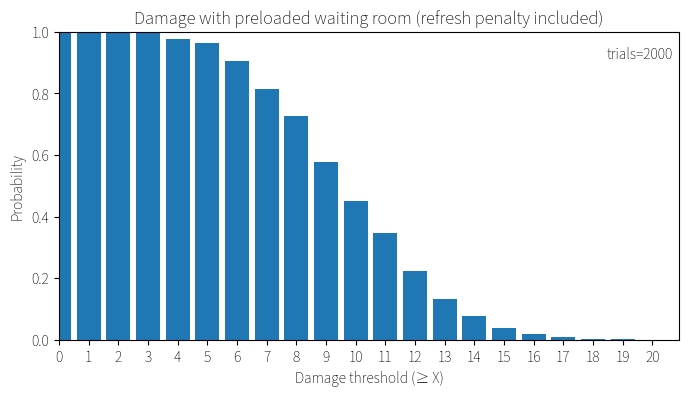

(<Figure size 800x400 with 1 Axes>,
 <Axes: title={'center': 'Damage with preloaded waiting room (refresh penalty included)'}, xlabel='Damage threshold (≥ X)', ylabel='Probability'>)

In [3]:
realistic_damage_sequence = [
    DamageEvent(base_damage=2, is_attack=False),
    DamageEvent(base_damage=3, is_attack=True),
    DamageEvent(base_damage=3, is_attack=False),
    DamageEvent(base_damage=2, is_attack=False),
    DamageEvent(base_damage=3, is_attack=True),
    DamageEvent(base_damage=3, is_attack=False),
    DamageEvent(base_damage=2, is_attack=False),
    DamageEvent(base_damage=3, is_attack=True),
]

deck_with_waiting_room = DeckConfig(
    deck_cards=10,
    deck_climax_cards=3,
    attacking_deck_size=25,
    attacking_soul_trigger_cards=10,
    initial_waiting_room_cards=18,
    initial_waiting_room_climax_cards=4
)

mid_refresh_threshold = 7

chosen_trials_wr, history_wr = tune_trial_count(
    realistic_damage_sequence,
    deck_with_waiting_room,
    threshold=mid_refresh_threshold,
    target_error=0.02,
    min_trials=500,
    seed=WAITING_ROOM_SEED,
)

damages_with_refresh = simulate_trials(
    realistic_damage_sequence,
    deck_with_waiting_room,
    trials=chosen_trials_wr,
    seed=WAITING_ROOM_SEED,
)

probabilities_wr = probabilities_from_damages(damages_with_refresh)

show_histogram(
    probabilities_wr,
    title="Damage with preloaded waiting room (refresh penalty included)",
    trials=chosen_trials_wr,
    filename="../artifacts/damage_hist_waiting_room.png",
)


## メインフェイズ効果のシミュレーション方針

ユニットテストでは `seed_top_stack` を使って山札トップを固定したケースを検証しますが、ここでは実際のゲーム進行に近づけるため、メインフェイズやその後のバトルでは山札を積み込まずランダムに処理します。
各メインフェイズ手段で累積したダメージを保持したまま3回のバトルアタックに進み、分布を比較します。

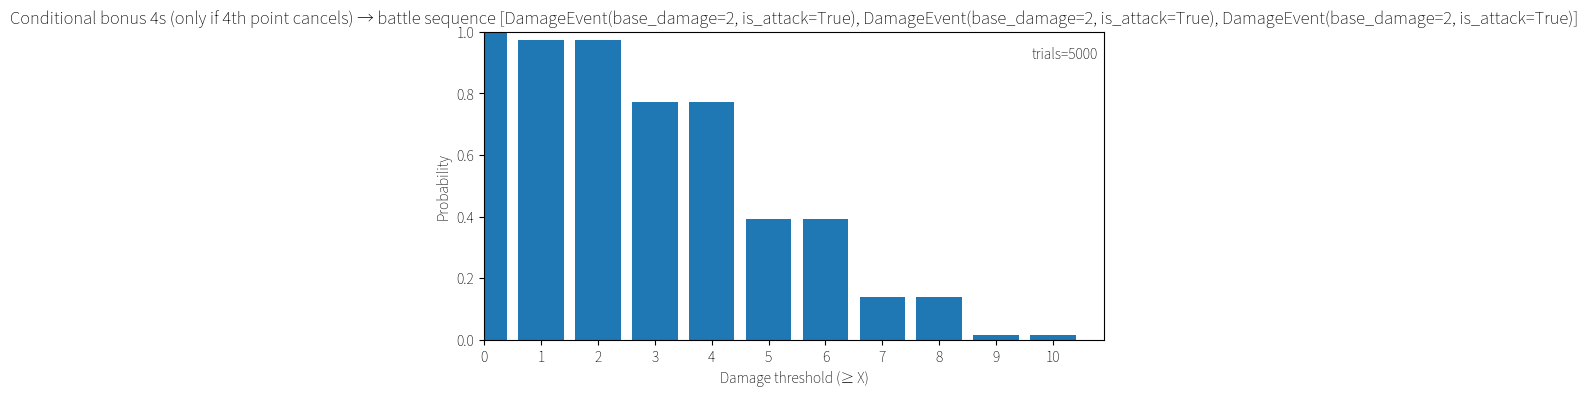

Conditional bonus 4s (only if 4th point cancels): mean=4.59, P(>=8)=0.138


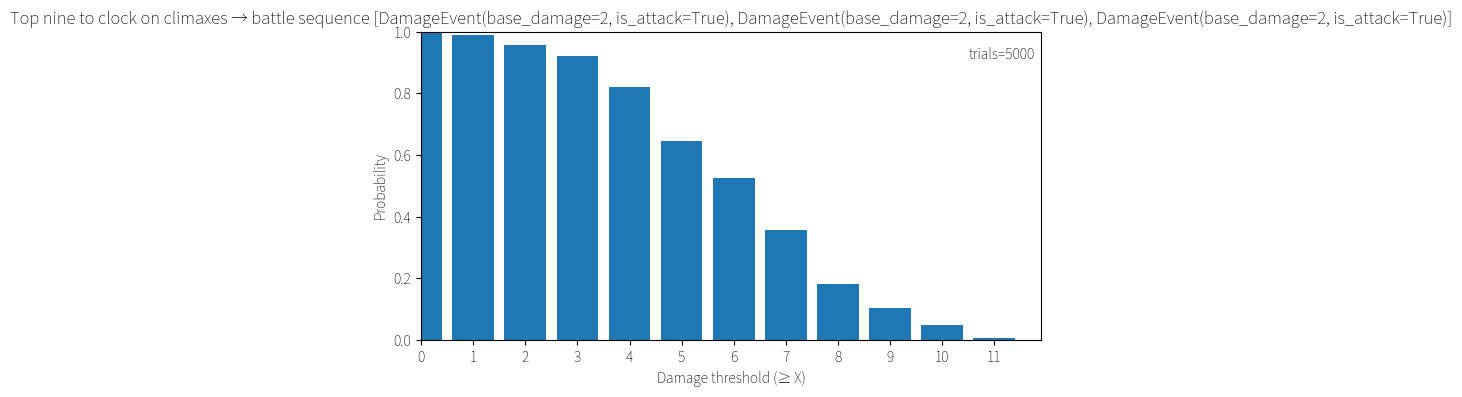

Top nine to clock on climaxes: mean=5.55, P(>=8)=0.180


In [4]:
battle_damage_sequence = [
    DamageEvent(base_damage=dmg)
    for dmg in (2, 2, 2)
]
baseline_deck = DeckConfig(
    deck_cards=20,
    deck_climax_cards=5,
    # waiting_room_cards=12,
    # waiting_room_climax_cards=3,
)

main_phase_lines = {
    "Conditional bonus 4s (only if 4th point cancels)": [
        main_phase_fourth_cancel_bonus_damage,
    ],
    "Top nine to clock on climaxes": [
        reveal_nine_clock_climaxes,
    ],
}

for label, steps in main_phase_lines.items():
    damages = run_main_phase_and_battle(
        battle_damage_sequence,
        baseline_deck,
        main_phase_steps=steps,
        trials=TRIALS,
        seed=MAIN_PHASE_SEED,
    )
    probabilities = probabilities_from_damages(damages)
    mean_damage = sum(damages) / len(damages)
    eight_plus = probabilities.get(8, 0)

    filename = f"../artifacts/{label.split()[0].lower()}_natural_flow.png"
    show_histogram(
        probabilities,
        title=f"{label} → battle sequence {battle_damage_sequence}",
        trials=TRIALS,
        filename=filename,
    )

    print(f"{label}: mean={mean_damage:.2f}, P(>=8)={eight_plus:.3f}")


## 魔石でストックを混ぜた後のアタック例

相手のストックと山札をまとめてシャッフルしてから同じ枚数のストックを積み直す魔石効果を `apply_magic_stone_effect` で再現します。
魔石による山札CX枚数のブレも含め、魔石処理→3点アタック×3回までを1トライアルとしてモンテカルロし、魔石未使用とのダメージ分布を比較します。

魔石後サンプル: 山札 24枚中CX 4枚 / ストック 8枚中CX 3枚


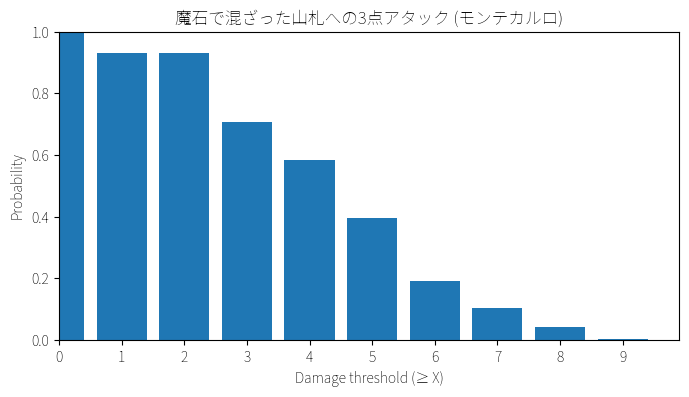

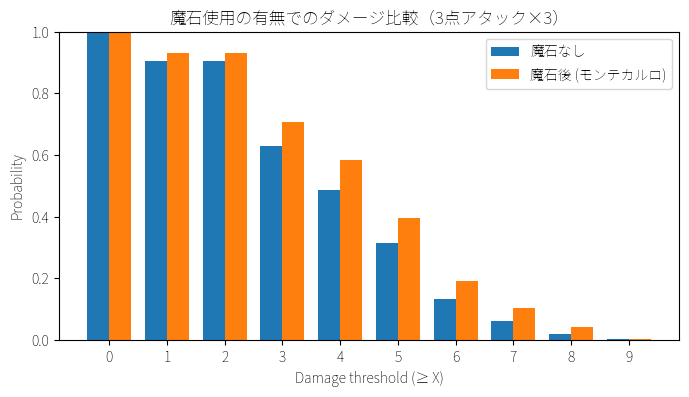

魔石なし: 平均3.45点 魔石あり: 平均3.89点


In [5]:
attack_sequence = [
    DamageEvent(base_damage=2),
    DamageEvent(base_damage=2),
    DamageEvent(base_damage=2),
]


def run_attacks(deck_config, *, trials=TRIALS, seed=BASE_SEED):
    damages = simulate_trials(
        attack_sequence,
        deck_config,
        trials=trials,
        seed=seed,
    )
    probabilities = probabilities_from_damages(damages)
    return damages, probabilities


pre_magic_deck = DeckConfig(
    deck_cards=24,
    deck_climax_cards=6,
    attacking_soul_trigger_cards=10,
    attacking_deck_size=25,
)
pre_magic_damages, pre_magic_probabilities = run_attacks(pre_magic_deck)


def run_magic_stone_then_attack(*, trials=TRIALS, seed=BASE_SEED):
    rng = random.Random(seed)
    damages = []

    for _ in range(trials):
        magic_result = apply_magic_stone_effect(
            stock_cards=8,
            stock_climax_cards=1,
            deck_cards=24,
            deck_climax_cards=6,
            rng=rng,
        )

        deck_after_magic = DeckConfig(
            deck_cards=magic_result.deck_cards,
            deck_climax_cards=magic_result.deck_climax_cards,
            attacking_soul_trigger_cards=10,
            attacking_deck_size=25,
        )

        trial_seed = rng.randint(0, 2**32 - 1)
        trial_damage = simulate_trials(
            attack_sequence,
            deck_after_magic,
            trials=1,
            seed=trial_seed,
        )[0]
        damages.append(trial_damage)

    probabilities = probabilities_from_damages(damages)
    return damages, probabilities


post_magic_damages, post_magic_probabilities = run_magic_stone_then_attack()
sample_magic = apply_magic_stone_effect(
    stock_cards=8,
    stock_climax_cards=1,
    deck_cards=24,
    deck_climax_cards=6,
    rng=random.Random(BASE_SEED),
)
print(
    f"魔石後サンプル: 山札 {sample_magic.deck_cards}枚中CX {sample_magic.deck_climax_cards}枚 / "
    f"ストック {sample_magic.stock_cards}枚中CX {sample_magic.stock_climax_cards}枚",
)

show_histogram(
    post_magic_probabilities,
    title="魔石で混ざった山札への3点アタック (モンテカルロ)",
    filename="../artifacts/magic_stone_post_hist.png",
)

thresholds = sorted(set(pre_magic_probabilities) | set(post_magic_probabilities))
bar_width = 0.38

fig_compare, ax_compare = plt.subplots(figsize=(8, 4))
ax_compare.bar(
    [t - bar_width / 2 for t in thresholds],
    [pre_magic_probabilities.get(t, 0) for t in thresholds],
    width=bar_width,
    label="魔石なし",
)
ax_compare.bar(
    [t + bar_width / 2 for t in thresholds],
    [post_magic_probabilities.get(t, 0) for t in thresholds],
    width=bar_width,
    label="魔石後 (モンテカルロ)",
)
ax_compare.set_xlabel("Damage threshold (≥ X)")
ax_compare.set_ylabel("Probability")
ax_compare.set_ylim(0, 1)
ax_compare.set_xticks(list(thresholds))
ax_compare.set_title("魔石使用の有無でのダメージ比較（2点アタック×3）")
ax_compare.legend()
fig_compare.savefig("../artifacts/magic_stone_comparison.png", bbox_inches="tight")
plt.show()

print(
    f"魔石なし: 平均{sum(pre_magic_damages)/len(pre_magic_damages):.2f}点",
    f"魔石あり: 平均{sum(post_magic_damages)/len(post_magic_damages):.2f}点",
)


魔石使用の有無によるダメージ分布と平均値を比較した結果のまとめ。
